# Penalties and Log Barriers, Part 2: Log Barriers

Based on Homework at https://www.user.tu-berlin.de/mtoussai/teaching/13-Optimization/
From M. Toussaint

In [1]:
using Plots
using LinearAlgebra
using Optim

# plotly()

pyplot()
# gr()

Plots.PyPlotBackend()

### Implement Log Barrier Method

Input: initial $x \in \mathbb{R}^{n},$ functions $f(x), g(x), \nabla f(x), \nabla g(x)$, tolerances $\theta, \epsilon$

Output: $x$

1: initialize $\mu=1$

2: repeat 

3:$\quad$ find $x \leftarrow \operatorname{argmin}_{x} f(x)-\mu \sum_{i} \log \left(-g_{i}(x)\right)$ with tolerance $10 \theta$

4:$\quad$ decrease $\mu \leftarrow \mu / 10$

5: until $|\Delta x|<\theta$ and $\forall_{i}: g_{i}(x)<\epsilon$

In [2]:
function gradAdaptToler2Var(xInit, funcX, gradX, stepInit, 
        tolerance = 0.5, maxIter = 10, verbose = false)
    
    # xInit is the initial point. Set up initial and error
    xNext = xInit
    xPrev = xInit
    xError = tolerance * 1000
    
    # Step size
    stepNext = stepInit
    stepUpFactor = 1.2
    stepDownFactor = 0.5
    
    # Save key data
    iterations = []
    steps = []
    push!(iterations, xInit)
    push!(steps, stepInit)
    
    numIter = 1
    
    while xError > tolerance
        
        if verbose
            println("Steping at $stepNext")
        end
        
        # ------------------
        # Begin Main part of Algorithm
        # ------------------
        if verbose
            println("Calculating the gradient")
        end
        # Calculate the gradient
        g = gradX(xNext)
        if verbose
            println("Updating x-position")
        end
        # Calcuclate the next step
        xNext = xNext - stepNext * g / norm(g, 2)
        
        # Adaptive Step Sizing
        if verbose
            print("Moved to ")
            print(funcX(xNext))
            print(" at ")
            println(xNext)
        end
        
        if funcX(xNext) <= funcX(xPrev)
            # Moved towards the minimum
            
            # Increase Stepsize
            stepNext = stepUpFactor * stepNext
            
            # Update the error
            xError = norm(xPrev - xNext, 2)
            
            # Accept Step
            xPrev = xNext
            
            if verbose
                println("Accepted")
            end
        else
            # Decrease Stepsize
            stepNext = stepDownFactor * stepNext
            
            # Reject Step
            if verbose
                println("Rejected")
            end
        end
        
        # ------------------
        # Save the iteration data
        # ------------------
        
        push!(iterations, xNext)
        push!(steps, stepNext)
        
        # ------------------
        # End Criteria
        # ------------------
        
        # Prevent the while loop going forever 
        # in case there is no convergence.
        if numIter >= maxIter
           break
        else
            numIter += 1
        end
    end
    
    println("Finished in $numIter of $maxIter")
#     println(steps)
    
    return iterations, steps
    
end

gradAdaptToler2Var (generic function with 4 methods)

In [3]:
function logBarrier(xInit, fFun, gFunArr, dfdx, dgdxArr, tolx, tolg, maxIter = 10, verbose = false)
    mu = 1.1
    
    veryLargeNum = (1/mu) * 10^10
    
    numIter = 1
    xError = tolx * 1000
    
    xNext = xInit
    xPrev = xInit
    
    lbIterations = [xInit]
    
    # Modified log to deal with negative inputs
    function modLog(x)
        if x < 0
            return -veryLargeNum
        else
            return log(x)
        end
    end
    
    # Format the constraints with base fun
    function sumfglog(x, mu)
        val = fFun(x)
        for i in 1:length(x)
            
            valg = mu * modLog(-gFunArr[i](x))
            val -= valg
            
            if verbose
                print("Log Constraint $i: ")
                println(valg)
            end
        end
        return val
    end
    
    # Format the derivative of the constraints
    function sumdfgdxlog(x, mu)
        val = dfdx(x)
#         print("Negative Gradient from Function: ")
#         println(val)
        for i in 1:length(x)
            
            valg = gFunArr[i](x)
            
            if valg != 0
                valThisConstraint = -mu * dgdxArr[i](x) / valg
                val += valThisConstraint
            else
                valThisConstraint = [-veryLargeNum, -veryLargeNum]
                val += valThisConstraint
            end
            
#             print("Negative Gradient from Contraint $i: ")
#             println(valThisConstraint)
        end
        
#         print("Negative Gradient Total: ")
#         println(val)
        
        return val
    end
    
    condEnd = false
    
    while !condEnd
        if verbose
            println("On iteration $numIter")
        end
        
        xPrev = xNext
        
        if verbose && (numIter == 1)
            print("Test Base Function: ")
            println(fFun(xNext))

            print("Test Objective Function: ")
            println(sumfglog(xNext, mu))
            
            print("Test Base Function Gradient: ")
            println(dfdx(xNext))

            print("Test Objective Function Gradient: ")
            println(sumdfgdxlog(xNext, mu))
        end
        
        println("--------------")
        print("Test Objective Function: ")
        println(sumfglog(xNext, mu))
        
        print("Test Objective Function Gradient: ")
        println(sumdfgdxlog(xNext, mu))
        println("--------------")
        
#         gradAdaptToler2Var(xInit, funcX, gradX, stepInit, 
#                     tolerance = 0.5, maxIter = 10, verbose = false)
        
        # Using Gradient Descent
#         iterations, steps = gradAdaptToler2Var(xNext, x -> sumfglog(x, mu), x -> sumdfgdxlog(x, mu), 0.4, tolx * 10, maxIter, false)
        
#         xNext = iterations[length(iterations)]
        
        # Using COTS solution
        result = optimize(x -> sumfglog(x, mu), xNext, BFGS())
        xNext = result.minimizer
        
        push!(lbIterations, xNext)
        
        # ------------------
        # Update
        # ------------------
        mu = mu / 10
        xError = norm(xNext - xPrev, 2)
        
        if verbose
            print("Next step: ")
            println(xNext)
            print("Error: ")
            println(xError)
        end
        
        # ------------------
        # End Criteria
        # ------------------
        
        if xError < tolx
            println("x Error Met at $xError")
            condEnd = true
            for i in 1:length(gFunArr)
                errG = abs(gFunArr[i](xNext))
                println("g$i Error Met at $errG")
                met = (errG <= tolg)
                condEnd = condEnd && met
            end
        end
        
        # Prevent the while loop going forever 
        # in case there is no convergence.
        if numIter >= maxIter
            condEnd = true
        else
            numIter += 1
        end
    end
    
    println("Completed in $numIter Iterations")
    return lbIterations
    
end

logBarrier (generic function with 3 methods)

In [4]:
getCVal(c, i, n) = c^((i - 1) / (2 * (n - 1)));

function cMat(c, n)
    matA =  zeros(n, n)
    for i in [1:n;]
        matA[i, i] = getCVal(c, i, n)
    end
    return Diagonal(matA)
end

cMatHere = cMat(4, 2)
print(cMatHere)


# First, get the base function f(x)
fsq2C(x) = cMatHere[1, 1] * x[1]^2 + cMatHere[2, 2] * x[2]^2;
fhole2C(x) = 1 - exp(-(fsq2C(x)));

# Second, get the derivative of the base function f(x)
firstDervHole2(x) = [-fhole2C(x)+1 0; 0 -fhole2C(x)+1]
dfhole2(x) = 2 * cMatHere^2 * firstDervHole2(x) * x

# Third, get the sum of the constraint functions
# gCons(x) = [x'x - 1, x[length(x)] + 1 / 4]
# function g1(x)
#     val = x'x -1
#     if val <= 0
#         # Constraint Satisfied
#         return 0
#     else
#         return val
#     end
# end

g1(x) = x'x -1

# function g2(x)
#     val = x[length(x)] + 1/ 4
#     if val <= 0
#         # Constraint Satisfied
#         return 0
#     else
#         return val
#     end
# end

g2(x) = x[length(x)] + 1/4

function sumG(x)
    return g1(x) + g2(x)
end

# Fourth, get the derivative of the constraint functions
dgdx1(x) = 2 * x
dgdx2(x) = [0, 1]
sumdgdx(x) = dgdx1(x) + dgdx2(x)

[1.0 0.0; 0.0 2.0]

sumdgdx (generic function with 1 method)

In [5]:
# sqrPenMethod(xInit, fFun, gFun, dfdx, dgdx, tolx, tolg, maxIter = 10)

xInit1 = [0.5, -0.5]
tolx1 = 0.01
tolg1 = 0.001
maxIt1 = 20

lbIters = logBarrier(xInit1, fhole2C, [g1, g2], dfhole2, [dgdx1, dgdx2], tolx1, tolg1, maxIt1);

--------------
Test Objective Function: 2.815019143106805
Test Objective Function Gradient: [2.67237, 0.310534]
--------------
--------------
Test Objective Function: 0.6718244272270798
Test Objective Function Gradient: [4.54123e-12, -2.22859]
--------------
--------------
Test Objective Function: 0.23803382260359643
Test Objective Function Gradient: [-1.6338e-11, -2.06306]
--------------
--------------
Test Objective Function: 0.1331922036929139
Test Objective Function Gradient: [-1.45801e-12, -1.73558]
--------------
--------------
Test Objective Function: 0.11934361280827682
Test Objective Function Gradient: [-1.47234e-12, -1.68297]
--------------
x Error Met at 0.0011163440240455347
g1 Error Met at 0.9374376396848129
g2 Error Met at 0.00012468953541383554
--------------
Test Objective Function: 0.11771275329730702
Test Objective Function Gradient: [-1.47381e-12, -1.67744]
--------------
x Error Met at 0.00011147848377046632
g1 Error Met at 0.9374933942996464
g2 Error Met at 1.32110

In [6]:
function modLog(x)
    if x < 0
        return -10^6
    else
        return log(x)
    end
end

muTest = 0.1

@time result2 = optimize(x -> fhole2C(x) - muTest * modLog(-g1(x)) - muTest * modLog(-g2(x)), xInit1, BFGS())

  0.078853 seconds (183.30 k allocations: 9.706 MiB, 10.02% gc time)


 * Status: success

 * Candidate solution
    Minimizer: [8.83e-13, -3.37e-01]
    Minimum:   4.594291e-01

 * Found with
    Algorithm:     BFGS
    Initial Point: [5.00e-01, -5.00e-01]

 * Convergence measures
    |x - x'|               = 2.89e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.57e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 4.58e-12 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    7
    f(x) calls:    18
    ∇f(x) calls:   18


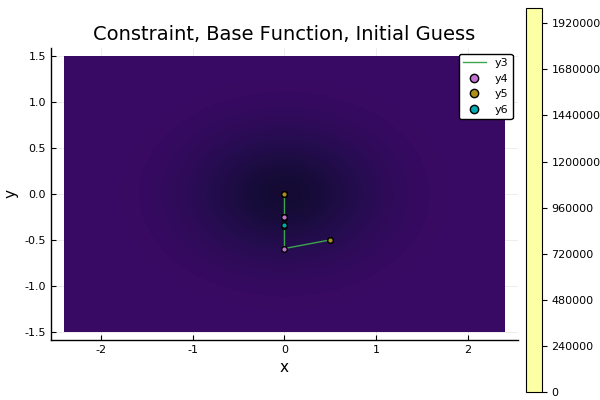

In [7]:
function modLog(x)
    if x < 0
        return -10^6
    else
        return log(x)
    end
end

xVals = [r[1] for r in lbIters]
yVals = [r[2] for r in lbIters]

gxrange = -2.4:0.01:2.4
gyrange = -1.5:0.01:1.5

gCons2(x) = [x[1]^2 + x[2]^2 - 1, x[2] + 1 / 4]
fhole2CPlot(x, y) = fhole2C([x, y])

# gCons2Plot1Satisfied(x, y) = gCons2([x, y])[1] < 0
# gCons2Plot2Satisfied(x, y) = gCons2([x, y])[2] < 0

# plt2 = contour(gxrange, gyrange, gCons2Plot2Satisfied, nlevels = 25, fill = true, aspectratio = :equal, seriesalpha = 0.1)
# plt1 = contour!(gxrange, gyrange, gCons2Plot1Satisfied, nlevels = 25, fill = true, aspectratio = :equal, seriesalpha = 0.1)

contour(gxrange, gyrange, (x,y) -> -modLog(-g1([x, y])) - modLog(-g2([x, y])), nlevels = 25, fill = true, 
                aspectratio = :equal, seriesalpha = 0.2, clims=(-1.0,10.0))

baseFunc = contour!(gxrange, gyrange, fhole2CPlot, nlevels = 25, fill = true, aspectratio = :equal, seriesalpha = 0.2, clims=(-1.0,10.0))

plot!(xVals, yVals)
scatter!(xVals, yVals)
scatter!([xVals[1], xVals[length(xVals)]], [yVals[1], yVals[length(yVals)]])
scatter!([result2.minimizer[1]],[result2.minimizer[2]])

xlabel!("x")
ylabel!("y")
title!("Constraint, Base Function, Initial Guess")

In [8]:
showRegionsSeparate = false
showOverlayed = false
showSummed = false

if showRegionsSeparate
    plt1 = contour(gxrange, gyrange, (x,y) -> -modLog(-g1([x, y])), nlevels = 25, fill = true, 
                aspectratio = :equal, seriesalpha = 0.1, clims=(-1.0,10.0))
    display(plt1)

    plt2 = contour(gxrange, gyrange, (x,y) -> -modLog(-g2([x, y])), nlevels = 25, fill = true, 
                    aspectratio = :equal, seriesalpha = 0.1, clims=(-1.0,10.0))
    display(plt2)
end

if showOverlayed
    plt1 = contour(gxrange, gyrange, (x,y) -> -modLog(-g1([x, y])), nlevels = 25, fill = true, 
                aspectratio = :equal, seriesalpha = 0.2, clims=(-1.0,10.0))
    contour!(gxrange, gyrange, (x,y) -> -modLog(-g2([x, y])), nlevels = 25, fill = true, 
                    aspectratio = :equal, seriesalpha = 0.1, clims=(-1.0,10.0))
    display(plt1)
end
    
if showSummed
    plt1 = contour(gxrange, gyrange, (x,y) -> -modLog(-g1([x, y])) - modLog(-g2([x, y])), nlevels = 25, fill = true, 
                aspectratio = :equal, seriesalpha = 0.2, clims=(-1.0,10.0))
    display(plt1)
end

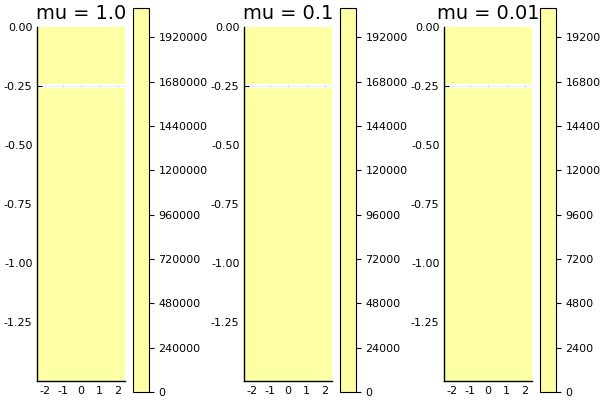

In [9]:
# Format the constraints with base fun
function sumfglogTest(x, mu)
    val = fhole2C(x)
    
    gFunArrTest = [g1, g2]
    
    for i in 1:length(x)
        valg = mu * modLog(-gFunArrTest[i](x))
        val -= valg
    end
    return val
end

muTest = [1, 0.1, 0.01]
climMax = 5.0
numlvls = 25

gyrange2 = -1.5:0.01:0.0

c1 = contour(gxrange, gyrange2, (x,y) -> sumfglogTest([x,y], muTest[1]), nlevels = numlvls, fill = true, 
                seriesalpha = 0.3, clims=(-1.0,climMax), title = "mu = " * string(muTest[1]))
c2 = contour(gxrange, gyrange2, (x,y) -> sumfglogTest([x,y], muTest[2]), nlevels = numlvls, fill = true, 
                seriesalpha = 0.3, clims=(-1.0,climMax), title = "mu = " * string(muTest[2]))
c3 = contour(gxrange, gyrange2, (x,y) -> sumfglogTest([x,y], muTest[3]), nlevels = numlvls, fill = true, 
                seriesalpha = 0.3, clims=(-1.0,climMax), title = "mu = " * string(muTest[3]))

plot(c1, c2, c3, layout = (1, 3))